# library

In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import FinanceDataReader as fdr

import datetime as dt

import numpy as np

from tqdm import tqdm #진행바
from tqdm.notebook import tqdm

#시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(mpl.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))


#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')


import warnings
warnings.filterwarnings('ignore')

# GPU
import tensorflow as tf

#https://www.tensorflow.org/guide/gpu#allowing_gpu_memory_growth
#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
#지정해서 쓰고 싶으면 model 쓸 때는 with 구문 안에 넣기

matplotlib version: 3.4.2
seaborn version: 0.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# data load 및 classification 전처리

In [2]:
df = pd.read_csv('stock_2018_10days.csv')
df['Next_Change'] = np.where(df['Next_Change']>0.05, 1, 0)

## 머신러닝 K-fold 교차 검증(cross validation)
데이터를 5-fold 교차검증으로 8개 모델을 학습하고 예측하여 평가한다.

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import time

results=[]

def classification(model_):
    
    # data load
    df_ = pd.read_csv('stock_2018_10days.csv')
    df_['Next_Change'] = np.where(df_['Next_Change']>0.05, 1, 0)
    
    # data split X, y
    X = df_.iloc[:,2:-1]
    y = df_.iloc[:,-1]
    i=0

    # Cross Validation
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 나누는 행위 5번 진행함.; 학습  : test = 4 : 1 random split
    for train_idx, test_idx in tqdm(sss.split(X,y)):
        x_train = df_.iloc[train_idx,2:-1]
        y_train = df_.iloc[train_idx,-1]
        x_test = df_.iloc[test_idx,2:-1]
        y_test = df_.iloc[test_idx,-1]
        
        # start_time = time.time() #-------------------------------------------
        _ = model_.fit(x_train, y_train)
        # training_time = time.time() - start_time #-------------------------------------------
        
        y_pred_train = model_.predict(x_train) 
        y_pred_test = model_.predict(x_test) # 예측
        accuracy_train = accuracy_score(y_train, y_pred_train) # 설명변수 x_train에 대한 반응변수 y_train 예측의 정확도. 이미 학습할 때 사용한 데이터이므로 답을 아는 상태라 소용이 없다고 생각하면 됨.
        accuracy_test = accuracy_score(y_test, y_pred_test) # 학습에 사용하지 않은 설명변수 x_train에 대한 반응변수 y_test 예측의 정확도. 이게 늘 말하는 그 정확도임.
        roc_auc = roc_auc_score(y_test, y_pred_test)
        
        dummy = DummyClassifier(strategy = 'stratified', random_state = 1) # strategy 옵션: 'stratified', 'uniform', 'most_frequent'
        _ = dummy.fit(x_train, y_train)
        dummy_score = dummy.score(x_test, y_test)
        
        results.append([i,f'{str(model)[:str(model).index("(")]}',accuracy_train,accuracy_test, roc_auc, dummy_score])#, training_time
        i+=1
        
        

In [27]:
%%time

# 1. Logistic regression    
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
temp = classification(model)


# 2. Decision tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
temp = classification(model)


# 3. Support vector machine
from sklearn.svm import SVC
model = SVC()
temp = classification(model)


# 4. Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
temp = classification(model)


# 5. K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
temp = classification(model)


# 6. Random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
temp = classification(model)


# 7. Gradient boosing
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
temp = classification(model)


# 8. Neural network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=1000)
temp = classification(model)


results # append 이미 되고있었구나,,, 그래서 뒤에서 5개만 뽑아서 보는거였구나,,,
# # 형태: i번째 학습, 학습 모델, train 정확도, test 정확도(최종정확도) 학습에 걸린 시간

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 4min 3s, sys: 2min 21s, total: 6min 24s
Wall time: 2min 25s


[[0,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.5,
  0.844488188976378],
 [1,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.5,
  0.8366141732283464],
 [2,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.5,
  0.8405511811023622],
 [3,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.5,
  0.844488188976378],
 [4,
  'LogisticRegression',
  0.917200591424347,
  0.9173228346456693,
  0.5,
  0.844488188976378],
 [0,
  'DecisionTreeClassifier',
  1.0,
  0.8287401574803149,
  0.5167075413856529,
  0.844488188976378],
 [1,
  'DecisionTreeClassifier',
  1.0,
  0.8740157480314961,
  0.5197220519108932,
  0.8366141732283464],
 [2,
  'DecisionTreeClassifier',
  1.0,
  0.8503937007874016,
  0.5501737175556918,
  0.8405511811023622],
 [3,
  'DecisionTreeClassifier',
  1.0,
  0.844488188976378,
  0.5252912323727774,
  0.844488188976378],
 [4,
  'DecisionTreeClassifier',
  1.0,
  0.8484251968503937,
  0.49

## 교차검증 결과 종합

In [28]:
df_results =pd.DataFrame(data=results, 
                columns= ['iter','method','accuracy_train','accuracy_test', 'roc_auc', 'dummy'])#,'training_time'
df_results

,iter,method,accuracy_train,accuracy_test,roc_auc,dummy
0,0,LogisticRegression,0.917201,0.917323,0.500000,0.844488
1,1,LogisticRegression,0.917201,0.917323,0.500000,0.836614
2,2,LogisticRegression,0.917201,0.917323,0.500000,0.840551
3,3,LogisticRegression,0.917201,0.917323,0.500000,0.844488
4,4,LogisticRegression,0.917201,0.917323,0.500000,0.844488
5,0,DecisionTreeClassifier,1.000000,0.828740,0.516708,0.844488
6,1,DecisionTreeClassifier,1.000000,0.874016,0.519722,0.836614
7,2,DecisionTreeClassifier,1.000000,0.850394,0.550174,0.840551
8,3,DecisionTreeClassifier,1.000000,0.844488,0.525291,0.844488
9,4,DecisionTreeClassifier,1.000000,0.848425,0.494942,0.844488


## 테스트 데이터셋 정확도 플랏

In [42]:
# df_results['accuracy_test'].sort_values(ascending = True)
df_results.groupby('method').mean().sort_values('accuracy_test')['accuracy_test']

method
GaussianNB                    0.250000
MLPClassifier                 0.838976
DecisionTreeClassifier        0.849213
GradientBoostingClassifier    0.909055
KNeighborsClassifier          0.913780
RandomForestClassifier        0.914567
LogisticRegression            0.917323
SVC                           0.917323
Name: accuracy_test, dtype: float64

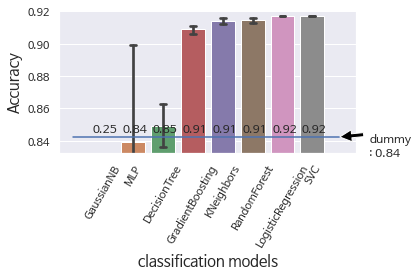

In [142]:
ax = sns.barplot(x="method", y="accuracy_test", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_test').index)
_ = ax.set_xticks(range(8))

################################################################################
# xticklabels
dummy_mean = df_results.groupby('method').mean().sort_values('accuracy_test')['dummy'].mean()
_ = ax.set(ylim=(dummy_mean - 0.01, 0.921))


tick_list = []
for i in ax.get_xticklabels():
    text = str(i).split(',')[2].split("'")[1]
    if 'Classifier' in text:
        text = text[:text.index("C")]
    tick_list.append(text)
# tick_list
################################################################################

_ = ax.set_xticklabels(tick_list,rotation=60); # ax.get_xticklabels(), ## 테스트 데이터셋 정확도 플랏

_ = ax.set_xlabel("classification models", fontsize = 15)
_ = ax.set_ylabel("Accuracy", fontsize = 15)

val = df_results.groupby('method').mean().sort_values('accuracy_test')['accuracy_test']
cnt = 0
for i in range(8):
    _ = ax.text(cnt-0.35, 0.845, f'{val[i]:.2f}')
    cnt += 1

_ = ax.plot([-1,8], [dummy_mean, dummy_mean])
_ = ax.annotate(f'dummy\n: {dummy_mean:.2f}', xy = (7.8, dummy_mean), xytext = (8.9, 0.83),
               arrowprops = dict(facecolor = 'black', shrink = 0.1),)

_ = plt.tight_layout()

## 훈련-테스트 데이터셋 정확도 플랏

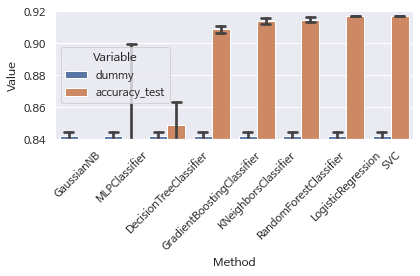

In [34]:
tidy = df_results[['method', 'dummy', 'accuracy_test']].melt(id_vars='method').rename(columns=str.title)
ax = sns.barplot(x="Method", y="Value", hue='Variable', data=tidy, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_test').index)
_ = ax.set(ylim=(0.84, 0.92))
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45);
_ = plt.tight_layout()

## roc-auc plot

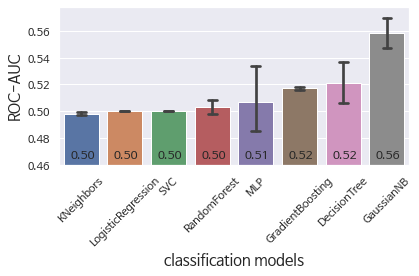

In [146]:
ax = sns.barplot(x="method", y="roc_auc", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('roc_auc').index)
_ = ax.set_xticks(range(8))
_ = ax.set(ylim=(0.46, 0.578))

# xticklabels
tick_list = []
for i in ax.get_xticklabels():
    text = str(i).split(',')[2].split("'")[1]
    if 'Classifier' in text:
        text = text[:text.index("C")]
    tick_list.append(text)
# tick_list

_ = ax.set_xticklabels(tick_list,rotation=45);## 테스트 데이터셋 정확도 플랏

_ = ax.set_xlabel("classification models", fontsize = 15)
_ = ax.set_ylabel("ROC-AUC", fontsize = 15)

val = df_results.groupby('method').mean().sort_values('roc_auc')['roc_auc']
cnt = 0
for i in range(8):
    _ = ax.text(cnt-0.25, 0.465, f'{val[i]:.2f}')
    cnt += 1

_ = plt.tight_layout()

# 더미

In [25]:
# random_state: 값이 계속 똑같이 나오게 하기 위해 설정하는 것.

# 라이브러리 임포트
from sklearn.dummy import DummyClassifier

# 데이터 로드
df = pd.read_csv('stock_2018_10days.csv')
df['Next_Change'] = np.where(df['Next_Change']>0.05, 1, 0)

# data split X, y
X = df.iloc[:,2:-1]
y = df.iloc[:,-1]

# Cross Validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 나누는 행위 5번 진행함.; 학습 : test = 4 : 1 random split
for train_idx, test_idx in tqdm(sss.split(X,y)):
    x_train = df.iloc[train_idx,2:-1]
    y_train = df.iloc[train_idx,-1]
    x_test = df.iloc[test_idx,2:-1]
    y_test = df.iloc[test_idx,-1]
    
#     start_time = time.time() #-------------------------------------------
    dummy = DummyClassifier(strategy = 'stratified', random_state = 1) # strategy 옵션: 'stratified', 'uniform', 'most_frequent'
    _ = dummy.fit(x_train, y_train)
    
#     training_time = time.time() - start_time #-------------------------------------------

    dummy.score(x_test, y_test)
#     dummy.predict(x_test)

0it [00:00, ?it/s]

0.844488188976378

0.8366141732283464

0.8405511811023622

0.844488188976378

0.844488188976378

[annotate](https://frhyme.github.io/python-lib/text-in-matplotlib/) <br>
[ax.plot](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=boubleman&logNo=221663334475)